In [1]:
_PROJECT_ID_IMAGE_EDITING = "velascoluis-dev-sandbox"
_REGION = 'us-central1'

In [2]:
import google.auth
from google.colab import files
from google.auth import transport
import google.auth.transport.requests
import time
import io
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter,ImageChops,ImageOps
import base64
import json
import cv2 as cv
import math

In [3]:
def extract_segment(original_image, segmentation_image, target = [255, 255, 255]):
    original_array = np.array(original_image)
    segmentation_array = np.array(segmentation_image)
    mask = np.all(segmentation_array == target, axis=-1)
    extracted_portion = original_array.copy()
    extracted_portion[~mask] = [255, 255, 255]
    result_image = Image.fromarray(extracted_portion)
    return result_image

def get_bytes_from_arr(im_arr, mode="RGB"):
  with io.BytesIO() as f:
    Image.fromarray(im_arr).convert(mode).save(
        f, format="PNG"
    )
    return f.getvalue()

def get_bytes_from_pil(image):
  byte_io_png = io.BytesIO()
  image.save(byte_io_png, 'PNG')
  return byte_io_png.getvalue()


def binary_mask(mask_image: np.ndarray, thresh: int = 179) -> np.ndarray:
  """Binary mask over a mask image."""
  mask_image[mask_image >= thresh] = 255
  mask_image[mask_image < thresh] = 0
  return mask_image

def display_pil_image(img):
  plt.axis('off')
  plt.imshow(img)
  print(f"image size(with x height): {img.size[0]} x {img.size[1]}")

def display_images(img_list):
  ncols = 2 if len(img_list) > 1 else 1
  nrows = math.ceil(len(img_list) / ncols)
  f, axs = plt.subplots(nrows, ncols, figsize=(10 * ncols, 10 * nrows))
  axs = axs.flatten() if len(img_list) > 1 else [axs]
  for i in range(0, len(img_list)):
    input_frame = np.asarray(img_list[i])
    axs[i].imshow(input_frame)
    axs[i].axis('off')

In [4]:
def vertex_editing(prompt,neg_prompt,original_image_pil,image_mask = None , seed = 1, imagen_version = "imagegeneration@004", is_product_image_flag = False):

  with io.BytesIO() as img_buf:
    original_image_pil.save(img_buf, format="PNG")
    im_b64_bytes = base64.b64encode(img_buf.getvalue()).decode("utf-8")
  if image_mask is not None:
    with io.BytesIO() as img_buf_mask:
      image_mask.save(img_buf_mask, format="PNG")
      im_b64_bytes_mask = base64.b64encode(img_buf_mask.getvalue()).decode("utf-8")

    data = {
        "instances": [{
          "prompt": prompt,
          "image": {
            "bytesBase64Encoded": im_b64_bytes
          },
          "mask": {
              "image": {
                "bytesBase64Encoded": im_b64_bytes_mask
            }
        },
        }],
        "parameters": {
          "negativePrompt": neg_prompt,
          "seed": seed,
          "isProductImage": is_product_image_flag,
        }
      }
  else:
     data = {
        "instances": [{
          "prompt": prompt,
          "image": {
            "bytesBase64Encoded": im_b64_bytes
          },
        }],
        "parameters": {
          "negativePrompt": neg_prompt,
          "seed": seed,
          "isProductImage": is_product_image_flag,
        }
      }

  url = f"https://{_REGION}-preprod-aiplatform.googleapis.com/v1/projects/{_PROJECT_ID_IMAGE_EDITING}/locations/{_REGION}/publishers/google/models/{imagen_version}:predict"
  credentials, project_id = google.auth.default()
  session = transport.requests.AuthorizedSession(credentials)
  response = session.post(url, json=data)

  prediction = json.loads(response.content)
  if "predictions" not in prediction:
    print(prediction)
  return [Image.open(io.BytesIO(base64.b64decode(pred["bytesBase64Encoded"]))) for pred in prediction["predictions"]]

In [5]:
img_original_path = "hanger_03.png"
img_mask_path = "hanger_03_mask_med.png"
img_mask_path_simple = "hanger_03_mask_simple.png"

image size(with x height): 984 x 1524


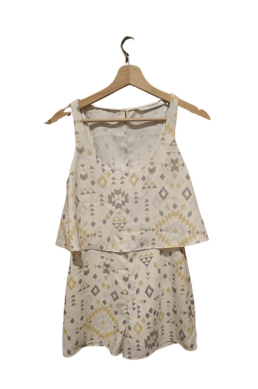

In [6]:
image_original_pil = Image.open(img_original_path).convert("RGB")
display_pil_image(image_original_pil)

image size(with x height): 984 x 1524


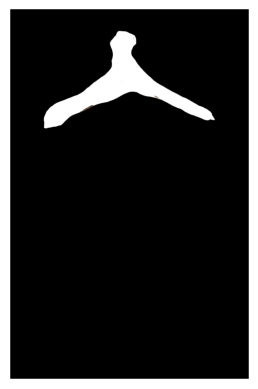

In [7]:
image_mask_pil = Image.open(img_mask_path).convert("RGB")
display_pil_image(image_mask_pil)

In [ ]:
image_mask_pil_inverted = ImageOps.invert(image_mask_pil)
display_pil_image(image_mask_pil_inverted)

image size(with x height): 984 x 1524


image size(with x height): 984 x 1524


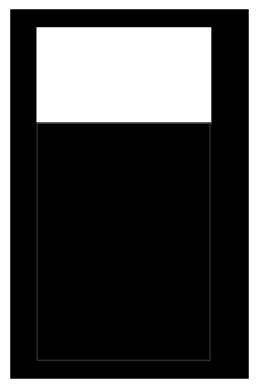

In [ ]:
image_mask_simple_pil = Image.open(img_mask_path_simple).convert("RGB")
display_pil_image(image_mask_simple_pil)

image size(with x height): 984 x 1524


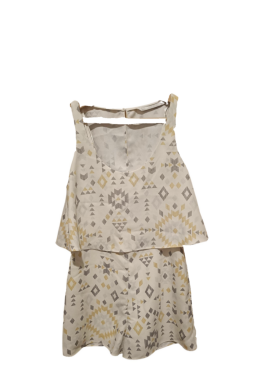

In [ ]:
image_mask_applied_pil = extract_segment(image_original_pil, image_mask_pil)
display_pil_image(image_mask_applied_pil)

In [12]:
#Test 1 - Background change with no mask
prompt = "a full dress in a white solid background"
neg_prompt = ''
generated_images = vertex_editing(prompt,neg_prompt,image_original_pil,is_product_image_flag = True,  imagen_version = "imagegeneration@002")
display_images(generated_images)

{'error': {'code': 400, 'message': 'Project `1063524325524` is not allowed to use Publisher Model `projects/velascoluis-dev-sandbox/locations/us-central1/publishers/google/models/imagegeneration@002`', 'status': 'FAILED_PRECONDITION'}}


KeyError: 'predictions'

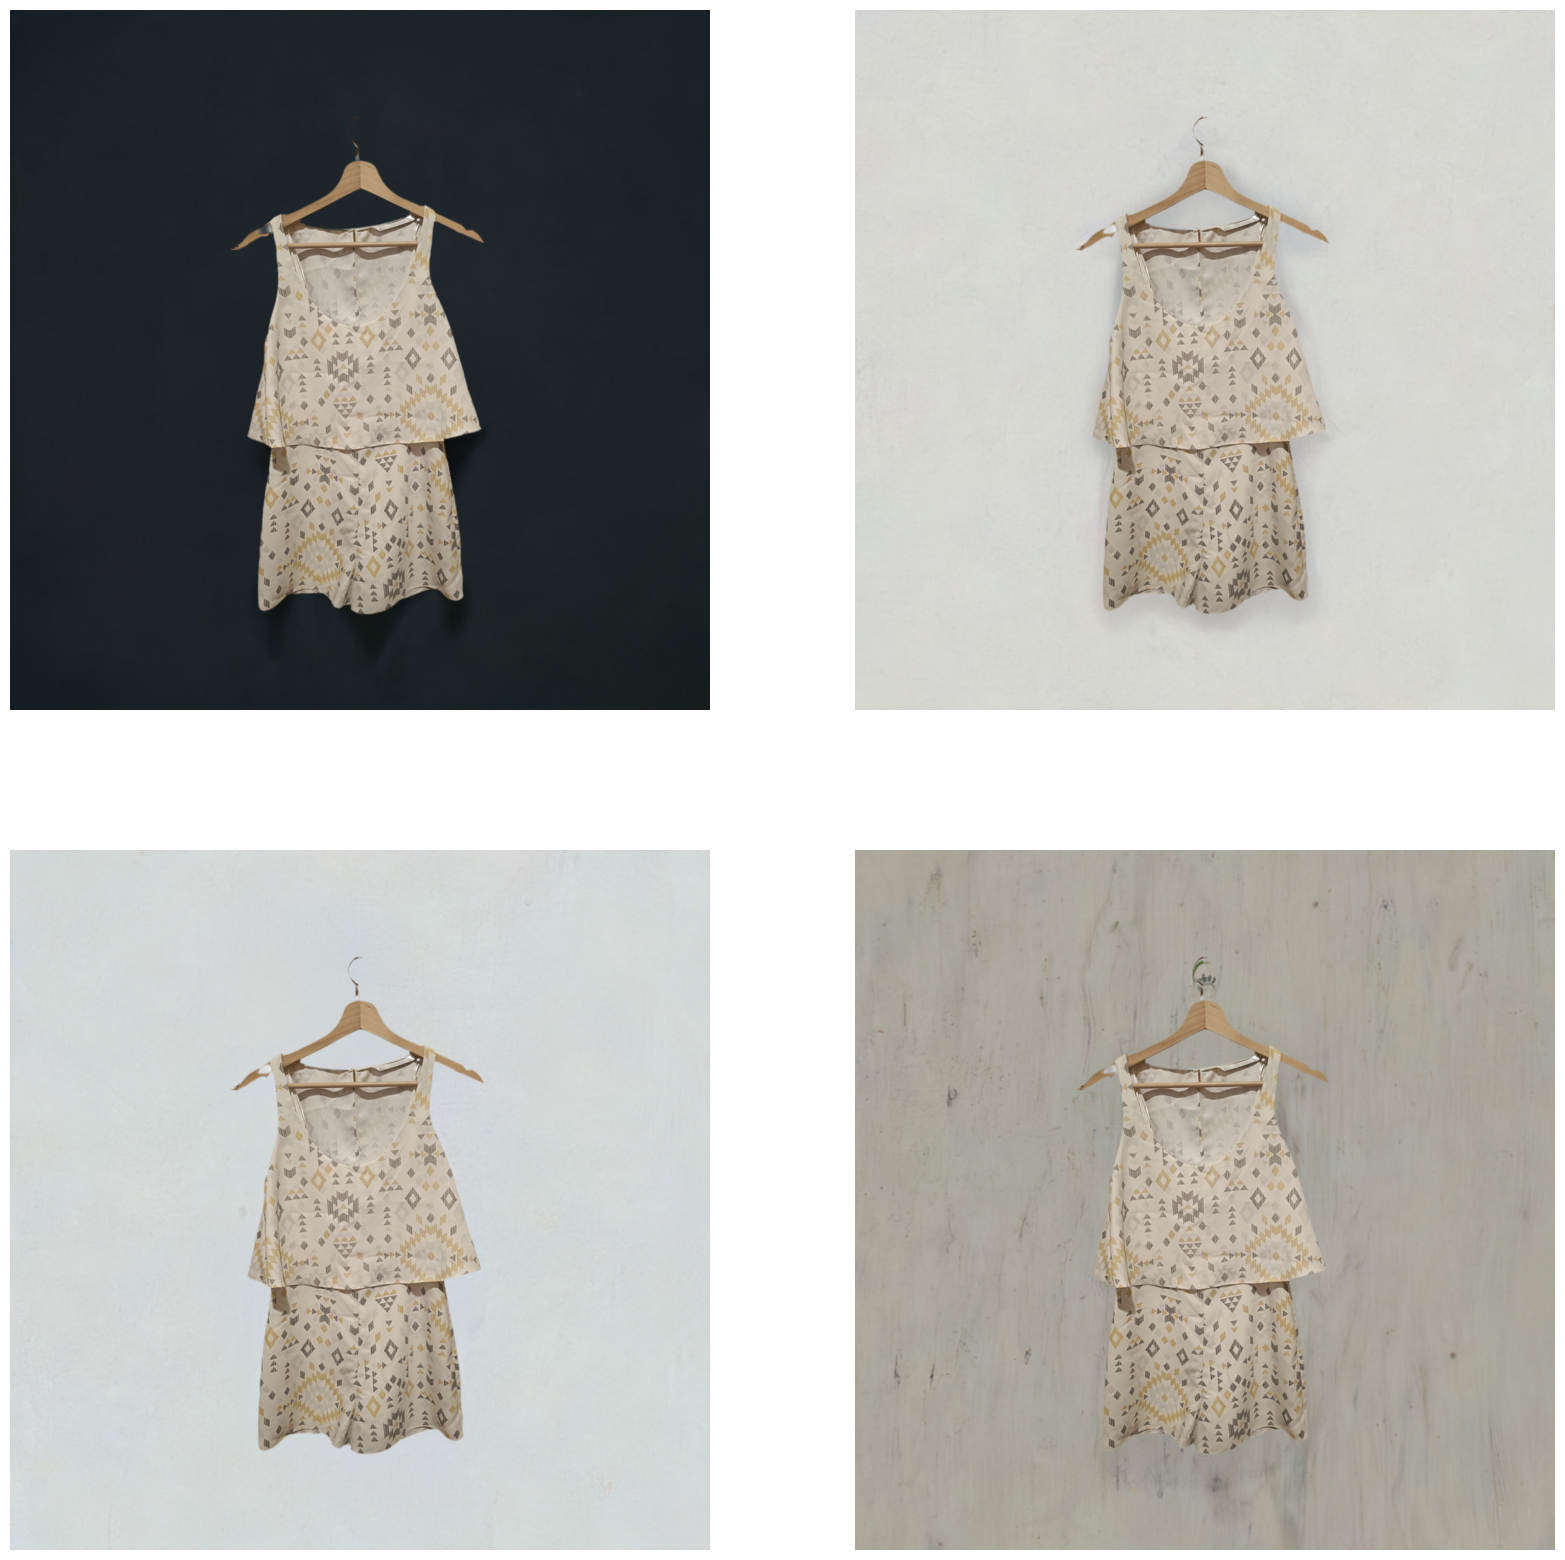

In [ ]:
#Test 2 - Background change with mask
prompt = "a full dress in a white solid background"
neg_prompt = ''
generated_images = vertex_editing(prompt,neg_prompt,image_original_pil,image_mask_pil,is_product_image_flag = True)
display_images(generated_images)

In [ ]:
#Test 3 - Background change with manually applied mask
prompt = "a full dress in a white solid background"
neg_prompt = ''
generated_images = vertex_editing(prompt,neg_prompt,image_mask_applied_pil,is_product_image_flag = True)
display_images(generated_images)

In [9]:
#Test 4 - Image inpainting with mask
prompt = "white solid background"
neg_prompt = 'hanger, wood hanger,perch, hook'
generated_images = vertex_editing(prompt,neg_prompt,image_original_pil,image_mask_pil,is_product_image_flag = False)
display_images(generated_images)

{'error': {'code': 400, 'message': 'Project `1063524325524` is not allowed to use Publisher Model `projects/velascoluis-dev-sandbox/locations/us-central1/publishers/google/models/imagegeneration@004`', 'status': 'FAILED_PRECONDITION'}}


KeyError: 'predictions'

In [ ]:
#Test 5 - Image inpainting with mask applied manually
prompt = "a full dress in a white solid background"
neg_prompt = ''
generated_images = vertex_editing(prompt,neg_prompt,image_mask_applied_pil,image_mask_pil,is_product_image_flag = False)
display_images(generated_images)